In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime
#from torch.utils.tensorboard import SummaryWriter

In [2]:
#torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 

#crypto provider
james = sy.VirtualWorker(hook, id="james")

compute_nodes = [alice, bob, chalie, dave]
frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
def generateLoadersPerClass(dataset):
    #loaders per class
    loaders_per_class = []
    for class_name in dataset.classes:
        # get the indices in the dataset that are relative to that class
        idx = [
            pos for pos, item in enumerate(dataset.samples)
            if item[1] == dataset.class_to_idx[class_name]]
        # construct the corresponding dataloader thanks to a SubsetRandomSampler
        loaders_per_class += [torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=SubsetRandomSampler(idx),
            **kwargs)]
    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign data
yalefaces = datasets.ImageFolder(root = 
                             '/Users/floriannuding/Desktop/Masterarbeit_Lokal/Datensätze_ready/Datensätze_ready/yalefaces_reworked',
                             transform=data_transform)
original_loaders = generateLoadersPerClass(yalefaces)

#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign test data
testdata = datasets.ImageFolder(root = 
                             '/Users/floriannuding/Desktop/Masterarbeit_Lokal/Datensätze_ready/Datensätze_ready/yalefaces_reworked',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)

# Load backdoor dataset

In [6]:
#backdoored = datasets.ImageFolder(root = 
#                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses',
#                             transform=data_transform)
##malicious data
#backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
#backdoored_loaders = generateLoadersPerClass(backdoored)
#
#
##malicious test data
#backdoored_test = datasets.ImageFolder(root = 
#                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses_test',
#                             transform=test_transform)
##set each image of backdoors to 001
#backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]
#dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

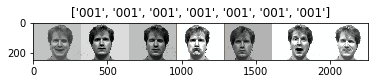

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = yalefaces.classes
# Get a batch of training data
inputs, classes = next(iter(original_loaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Secure Multiparty computation: send datasets to clients

In [9]:
remote_dataset = remote_dataset = (list(),)*len(compute_nodes)

#normal clients
for loader in original_loaders:
    for i in range(0,len(loader)*4): # run multiple times over the dataset to increase its size
        data,target = next(iter(loader))
        data = data.send(compute_nodes[i % len(compute_nodes)])
        target = target.send(compute_nodes[i % len(compute_nodes)])
        remote_dataset[i % len(compute_nodes)].append((data, target))

def update(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward() 
    optimizer.step() 
    return model 

#each client has its own model
alices_model = bobs_model = chalies_model = daves_model = Net().to(device)

#each client has its own optimization function
alices_opt = bobs_opt = chalies_opt = daves_opt = optim.SGD(alices_model.parameters(), lr=0.01)

models = [alices_model, bobs_model, chalies_model, daves_model]
params = [list(alices_model.parameters()), list(bobs_model.parameters()), list(chalies_model.parameters()), list(daves_model.parameters())]
optimizers = [alices_opt, bobs_opt, chalies_opt, daves_opt]

AssertionError: Torch not compiled with CUDA enabled

# Training Function

In [ ]:
#def train(epoch, normal_or_backdoored_dataset):
#    model.train()
#    totalloss = 0
#    number_iterations = 0
#    
#    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
#        number_iterations +=1
#        model.send(data.location) # 0) send the model to the right location
#        data, target = data.to(device), target.to(device)
#        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
#        output = model(data)  # 2) make a prediction
#        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
#        loss.backward() # 4) figure out which weights caused us to miss
#        optimizer.step() # 5) change those weights
#        model.get() # 6) get model (with gradients)
#            
#        #if batch_idx % 300 == 0:
#        loss = loss.get() # <-- NEW: get the loss back
#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
#                100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
#        totalloss += loss
#    print('Average training loss: {}'.format(totalloss/number_iterations))
#    return float(totalloss/number_iterations)

def trainSMPC(epoch):
    for data_index in range(len(remote_dataset[0])-1):
        # update remote models
        for remote_index in range(len(compute_nodes)):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
            
    
        # encrypted aggregation
        new_params = list()
        for param_i in range(len(params[0])):
            spdz_params = list()
            for remote_index in range(len(compute_nodes)):
                spdz_params.append(params[remote_index][param_i].copy().fix_precision().share(tuple(compute_nodes), crypto_provider=james).get())

            new_param = (spdz_params[0] + spdz_params[1] + spdz_params[2] + spdz_params[3]).get().float_precision()/2
            new_params.append(new_param)
            
        
        # cleanup
        with torch.no_grad():
            for model in params:
                for param in model:
                    param *= 0

            for model in models:
                model.get()

            for remote_index in range(len(compute_nodes)):
                for param_index in range(len(params[remote_index])):
                    params[remote_index][param_index].set_(new_params[param_index])

# Test Function

In [ ]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [ ]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
#model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("exp_faces_20191104-104602_epoch_80.pt"))
#optimizer = optim.SGD(model.parameters(), lr=0.01)

#Write to file:
#dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#
#f= open(("exp_faces_"+dateString+".txt"),"w+")
#
##EXP-setup
#csv_header = "#merge strategy: " + "sequential" + "\n"
#csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
#csv_header += "#batch size: " + str(batch_size) + "\n"
#csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
#csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
#csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
#csv_header += "#way backdoor looks like: " + "glasses" + "\n"
#csv_header += "#order of time: " + "backdoors last" + "\n"
#csv_header += "#attack model: " + "basic" + "\n"
#csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
#csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
#print(csv_header)
#f.write(csv_header)
#f.close()


#RUN training
for epoch in range(1, 201):
    print(f"Epoch {epoch}")
    #csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    #csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train normal
    trainSMPC(epoch)
    #csv_normal += str(avg_training_loss) + ";"
    #timestamp_normal = datetime.datetime.now().strftime("%H%M%S")
    
    #train backdoor
    #avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    #csv_backdoor += str(avg_training_backdoor_loss) + ";"
    #timestamp_backdoor = datetime.datetime.now().strftime("%H%M%S")

    #save after each 25 iterations
    #if epoch % 25 == 0:
    #    torch.save(model.state_dict(), ("exp_faces_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    #test_loss, acc = test(models[0], device, dataset_loader_backdoored_test, len(backdoored_test))
    #csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(models[0], device, test_loader, len(testdata))
    #csv_normal += str(test_loss) + ";" + acc + ";"

    #scheduler.step(test_loss)
    
    #timestamp
    #csv_normal += timestamp_normal + "\n"
    #csv_backdoor += timestamp_backdoor + "\n"
    
    #Write to file
    #f= open(("exp_faces_"+dateString+".txt"),"a+")
    #f.write(csv_backdoor)
    #f.write(csv_normal)
    #f.close()
    
    print(test_loss)

    



In [ ]:
alices_model

In [ ]:
#model = Net().to(device)
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
#test(model, device, test_loader)


In [ ]:
#remote_dataset = (list(),)*4
#remote_dataset = (list(),list())
alice, bob, chalie, dave
tuple(compute_nodes)

In [ ]:
#writer = SummaryWriter('runs/test')
#writer.add_graph(Net(), torch.randn(4, 3, 224, 224))